# Camera API demo (or something)

## Setup

### Modules

In [20]:
from pathlib import Path

import ids_peak.ids_peak as idsp
from matplotlib import pyplot as plt
import numpy as np

from cameraIDS import CameraIDS

### Data

In [2]:
DIR_CONFIGS = "configs"
FILENAME_CONFIG = "cam_ids_config.cset"

path_config = Path(DIR_CONFIGS) / FILENAME_CONFIG

### Initialization

In [3]:
idsp.Library.Initialize()

In [4]:
device_manager = idsp.DeviceManager.Instance()

In [5]:
def print_device_info(device_descriptor):
    name_model = device_descriptor.ModelName()
    name_interface = device_descriptor.ParentInterface().DisplayName()
    name_system = device_descriptor.ParentInterface().ParentSystem().DisplayName()
    version_system = device_descriptor.ParentInterface().ParentSystem().Version()

    print(name_model)
    print(name_interface)
    print(name_system)
    print(version_system)

In [6]:
device_manager.Update()
device_descriptor = device_manager.Devices()[0]
print_device_info(device_descriptor)

U3-36PxXLS-C
IDS U3V Interface
IDS GenICam Producer (U3V)
1.15.0.0


In [7]:
def get_device(device_manager):
    device_manager.Update()
    device_descriptors = device_manager.Devices()

    if device_descriptors.empty():
        print("No device found. Exiting Program.")
        return

    device = device_descriptors[0].OpenDevice(idsp.DeviceAccessType_Control)
    return device

In [8]:
device = get_device(device_manager)

In [9]:
camera = CameraIDS(device)

In [10]:
display(camera)

cameraIDS.CameraIDS(<ids_peak.ids_peak.Device; proxy of <Swig Object of type 'std::shared_ptr< peak::core::Device > *' at 0x763b7c3a0720> >)

In [11]:
print(camera)

U3-36PxXLS-C (IDS U3V Interface ; IDS GenICam Producer (U3V) v.1.15.0.0)


In [12]:
attributes = camera.get_attributes()
display(attributes)

['Root',
 'TLParamsLockedCategory',
 'AcquisitionControl',
 'TransferControl',
 'DeviceControl',
 'TestControl',
 'ManufacturerInfo',
 'FileAccessControl',
 'SequencerControl',
 'EventControl',
 'UserSetControl',
 'ProtectionControl',
 'LEDControl',
 'DigitalIOControl',
 'ImageFormatControl',
 'ImageCorrectionControl',
 'AnalogControl',
 'TransportLayerControl',
 'Trigger Selector',
 'Trigger Mode',
 'Trigger Source',
 'Trigger Activation',
 'Trigger Software',
 'Trigger Delay',
 'Trigger Divider',
 'Acquisition Mode',
 'Acquisition Frame Count',
 'Sensor Shutter Mode',
 'Acquisition Abort',
 'Acquisition Frame Rate Target',
 'SensorFrameTimeClocksTarget',
 'Acquisition Frame Rate Target Enable',
 'SensorLineClocks',
 'Acquisition Start',
 'Acquisition Stop',
 'SensorClockFrequency',
 'Exposure Time',
 'SensorExposureTimeClocks',
 'Acquisition Frame Rate',
 'SensorFrameTimeClocks',
 'Exposure Mode',
 'Transfer Control Mode',
 'Device Firmware Version',
 'Device User ID',
 'Device Reset

In [14]:
camera.load_settings(path_config)

In [15]:
camera.start_acquisition()

In [36]:
camera.start_capturing()

In [48]:
camera.get_value("ChunkModeActive")

NotFoundException: Error-Code: 11 (PEAK_RETURN_CODE_NOT_FOUND) | Error-Description: There is no node with the given name (ChunkModeActive)!

In [38]:
camera._capturing_thread

<Thread(Thread-4 (capture_threaded), stopped 129996130141760)>

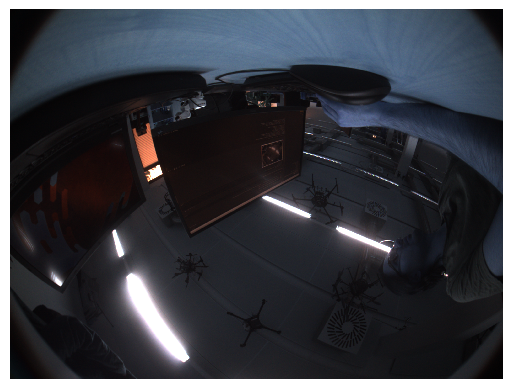

In [54]:
img = camera.capture()
plt.imshow(img.get_numpy_3D(), interpolation="nearest")
plt.axis("off")
plt.show()

In [27]:
camera.get_value("ChunkTimestamp")

NotFoundException: Error-Code: 11 (PEAK_RETURN_CODE_NOT_FOUND) | Error-Description: There is no node with the given name (ChunkTimestamp)!

In [18]:
camera.stop_acquisition()

In [23]:
for e in list(camera._nodemap.FindNode("UserSetSelector").Entries()):
    print(e.SymbolicValue())

Default
UserSet0
UserSet1
Linescan
LinescanHighSpeed
LongExposure
HighSpeed


In [24]:
camera._nodemap.FindNode("UserSetSelector").SetCurrentEntry("HighSpeed")
camera._nodemap.FindNode("UserSetLoad").Execute()
camera._nodemap.FindNode("UserSetLoad").WaitUntilDone()

BadAccessException: Error-Code: 4 (PEAK_RETURN_CODE_BAD_ACCESS) | Error-Description: Failed to write enumeration value. Enum entry is not writable : AccessException thrown in node 'UserSetSelector' while calling 'UserSetSelector.SetIntValue()' (file 'Enumeration.cpp', line 158)

In [25]:
camera.close()

In [26]:
idsp.Library.Close()

In [ ]:
# nodeMapRemoteDevice.FindNode("TimestampReset").Execute()
# nodeMapRemoteDevice.FindNode("TimestampReset").WaitUntilDone()